In [2]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np

# create an instance of the logger
logger = logging.getLogger()

# Change current directory to parent directory
import os
os.chdir("..")

In [4]:
# Define global variables
RAW_PATH_MERGED_DATA = 'data/processed/merged.csv'

# Check if the file exists
if os.path.exists(RAW_PATH_MERGED_DATA):
    # Load the file
    merged_data = pd.read_csv(RAW_PATH_MERGED_DATA)
    print(merged_data.head())
else:
    print("File not found:", RAW_PATH_MERGED_DATA)

              DateTime    Time_fault Fault  Time_scada  Error  \
0  2014-05-14 14:39:44  1.400096e+09    GF         NaN    NaN   
1  2014-05-14 14:50:24  1.400097e+09    GF         NaN    NaN   
2  2014-05-14 14:58:56  1.400098e+09    GF         NaN    NaN   
3  2014-05-14 15:09:36  1.400098e+09    GF         NaN    NaN   
4  2014-05-14 15:20:16  1.400099e+09    GF         NaN    NaN   

   WEC: ava. windspeed  WEC: max. windspeed  WEC: min. windspeed  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   WEC: ava. Rotation  WEC: max. Rotation  ...  Inverter averages  \
0                 NaN                 NaN  ...                NaN   
1                 NaN                 NaN  ...                

/var/folders/f1/tcfth2f16mv8s95myjjfx84h0000gn/T/ipykernel_52230/1649482415.py:7: DtypeWarning: Columns (2,70,71,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv(RAW_PATH_MERGED_DATA)


## Adding Seasonality (High or Low) as Feature for the Model

### Based Market Data Season Anaylsis, using Average and Max Settlement Point Price For Each Month In 2014

### We determined

#### Months of High Seasons as: **['Feb', 'Mar', 'Apr', 'May', 'Jun','Aug']**

#### Months of High Seasons as: **['Jan', 'Jul', 'Sep', 'Oct', 'Nov','Dec']**

In [5]:
# Define the mapping for high and low seasons
SEASON_MAPPING = {
    'Jan': 'Low',
    'Feb': 'High',
    'Mar': 'High',
    'Apr': 'High',
    'May': 'High',
    'Jun': 'High',
    'Jul': 'Low',
    'Aug': 'High',
    'Sep': 'Low',
    'Oct': 'Low',
    'Nov': 'Low',
    'Dec': 'Low'
}

# Convert the 'DateTime' column to datetime if not already
if 'DateTime' in merged_data.columns:
    merged_data['DateTime'] = pd.to_datetime(merged_data['DateTime'])
else:
    logger.error("DateTime column is missing from the dataset.")

# Extract the month from the 'DateTime' column and map it to the season
merged_data['Month'] = merged_data['DateTime'].dt.strftime('%b')  # Extract month abbreviation
merged_data['Season'] = merged_data['Month'].map(SEASON_MAPPING)  # Map month to season

# Display the updated dataset with the new 'Season' column
print(merged_data[['DateTime', 'Month', 'Season']].head())

             DateTime Month Season
0 2014-05-14 14:39:44   May   High
1 2014-05-14 14:50:24   May   High
2 2014-05-14 14:58:56   May   High
3 2014-05-14 15:09:36   May   High
4 2014-05-14 15:20:16   May   High


### Analyze season-wise statistics

In [6]:


# Optional: Analyze season-wise statistics
season_stats = merged_data.groupby('Season').agg({
    'WEC: ava. Power': ['mean', 'max'],  # Example columns for analysis
    'WEC: Production minutes': 'sum'
}).reset_index()

# Display the season-wise stats
print(season_stats)

  Season WEC: ava. Power         WEC: Production minutes
                    mean     max                     sum
0   High      840.817974  3070.0                621965.0
1    Low     1030.455417  3071.0                791445.0


### Adding Change in Wind as feature

In [7]:
# Ensure the 'WEC: ava. windspeed' column exists
if 'WEC: ava. windspeed' in merged_data.columns:
    # Calculate the wind change while handling nulls
    merged_data['Wind Change'] = merged_data['WEC: ava. windspeed'].fillna(method='ffill').diff()

    # Retain nulls in the new column where original column had nulls
    merged_data.loc[merged_data['WEC: ava. windspeed'].isnull(), 'Wind Change'] = None
else:
    logger.error("'WEC: ava. windspeed' column is missing from the dataset.")

### Adding Change in Energy as Feature

In [8]:
# Ensure the 'WEC: Production kWh' column exists
if 'WEC: Production kWh' in merged_data.columns:
    # Calculate the energy change while handling nulls
    merged_data['Energy Change'] = merged_data['WEC: Production kWh'].fillna(method='ffill').diff()

    # Retain nulls in the new column where the original column had nulls
    merged_data.loc[merged_data['WEC: Production kWh'].isnull(), 'Energy Change'] = None
else:
    logger.error("'WEC: Production kWh' column is missing from the dataset.")

### Adding Efficiency as Energy per Unit of Wind Speed

This measures how efficiently energy is generated relative to wind speed. High productivity would indicate efficient energy conversion.

In [9]:
# Ensure the necessary columns exist before calculating new features
if 'WEC: Production kWh' in merged_data.columns and 'WEC: ava. windspeed' in merged_data.columns:
    # Calculate efficiency: Energy per Unit of Wind Speed
    merged_data['Efficiency'] = merged_data['Energy Change'] / merged_data['WEC: ava. windspeed']
    
    # Handle cases where wind speed or energy is null
    merged_data.loc[
        (merged_data['Energy Change'].isnull()) | (merged_data['WEC: ava. windspeed'].isnull()),
        'Efficiency'
    ] = None
else:
    logger.error("Columns required for Efficiency ('WEC: Production kWh', 'WEC: ava. windspeed') are missing.")

### Adding Productivity as Energy per Unit of Time

This measures energy output per unit of operational time, highlighting periods of high or low performance.

In [10]:
# Ensure the 'DateTime' column exists to calculate time intervals for Productivity
if 'DateTime' in merged_data.columns:
    # Convert 'DateTime' to datetime if not already
    merged_data['DateTime'] = pd.to_datetime(merged_data['DateTime'], errors='coerce')
    
    # Sort data by DateTime
    merged_data = merged_data.sort_values('DateTime')
    
    # Calculate the time difference in hours
    merged_data['Time Interval (hours)'] = merged_data['DateTime'].diff().dt.total_seconds() / 3600
    
    # Calculate productivity: Energy per Unit of Time
    merged_data['Productivity'] = merged_data['Energy Change'] / merged_data['Time Interval (hours)']
    
    # Handle cases where time interval or energy is null
    merged_data.loc[
        (merged_data['Energy Change'].isnull()) | (merged_data['Time Interval (hours)'].isnull()),
        'Productivity'
    ] = None
else:
    logger.error("'DateTime' column is missing for Productivity calculation.")

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select temperature-related columns for PCA
temperature_columns = [
    'Sys 1 inverter 1 cabinet temp.',
    'Sys 1 inverter 2 cabinet temp.',
    'Sys 1 inverter 3 cabinet temp.',
    'Sys 1 inverter 4 cabinet temp.',
    'Sys 1 inverter 5 cabinet temp.',
    'Sys 1 inverter 6 cabinet temp.',
    'Sys 1 inverter 7 cabinet temp.',
    'Sys 2 inverter 1 cabinet temp.',
    'Sys 2 inverter 2 cabinet temp.',
    'Sys 2 inverter 3 cabinet temp.',
    'Sys 2 inverter 4 cabinet temp.',
    'Sys 2 inverter 5 cabinet temp.',
    'Sys 2 inverter 6 cabinet temp.',
    'Sys 2 inverter 7 cabinet temp.',
    'Spinner temp.',
    'Front bearing temp.',
    'Rear bearing temp.',
    'Pitch cabinet blade A temp.',
    'Pitch cabinet blade B temp.',
    'Pitch cabinet blade C temp.',
    'Rotor temp. 1',
    'Rotor temp. 2',
    'Stator temp. 1',
    'Stator temp. 2',
    'Nacelle ambient temp. 1',
    'Nacelle ambient temp. 2',
    'Nacelle temp.',
    'Nacelle cabinet temp.',
    'Main carrier temp.',
    'Rectifier cabinet temp.',
    'Yaw inverter cabinet temp.',
    'Fan inverter cabinet temp.',
    'Ambient temp.',
    'Tower temp.',
    'Control cabinet temp.',
    'Transformer temp.'
]

# Filter the dataset to include only relevant columns
temperature_data = merged_data[temperature_columns]

# Drop rows with missing values
temperature_data_cleaned = temperature_data.dropna()

# Standardize the data
scaler = StandardScaler()
temperature_scaled = scaler.fit_transform(temperature_data_cleaned)

# Apply PCA
pca = PCA(n_components=1)  # Reduce to a single component for Heat Index

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select temperature-related columns for PCA
temperature_columns = [
    'Sys 1 inverter 1 cabinet temp.',
    'Sys 1 inverter 2 cabinet temp.',
    'Sys 1 inverter 3 cabinet temp.',
    'Sys 1 inverter 4 cabinet temp.',
    'Sys 1 inverter 5 cabinet temp.',
    'Sys 1 inverter 6 cabinet temp.',
    'Sys 1 inverter 7 cabinet temp.',
    'Sys 2 inverter 1 cabinet temp.',
    'Sys 2 inverter 2 cabinet temp.',
    'Sys 2 inverter 3 cabinet temp.',
    'Sys 2 inverter 4 cabinet temp.',
    'Sys 2 inverter 5 cabinet temp.',
    'Sys 2 inverter 6 cabinet temp.',
    'Sys 2 inverter 7 cabinet temp.',
    'Spinner temp.',
    'Front bearing temp.',
    'Rear bearing temp.',
    'Pitch cabinet blade A temp.',
    'Pitch cabinet blade B temp.',
    'Pitch cabinet blade C temp.',
    'Rotor temp. 1',
    'Rotor temp. 2',
    'Stator temp. 1',
    'Stator temp. 2',
    'Nacelle ambient temp. 1',
    'Nacelle ambient temp. 2',
    'Nacelle temp.',
    'Nacelle cabinet temp.',
    'Main carrier temp.',
    'Rectifier cabinet temp.',
    'Yaw inverter cabinet temp.',
    'Fan inverter cabinet temp.',
    'Ambient temp.',
    'Tower temp.',
    'Control cabinet temp.',
    'Transformer temp.'
]

# Filter the dataset to include only relevant columns
temperature_data = merged_data[temperature_columns]

# Drop rows with missing values
temperature_data_cleaned = temperature_data.dropna()

# Standardize the data
scaler = StandardScaler()
temperature_scaled = scaler.fit_transform(temperature_data_cleaned)

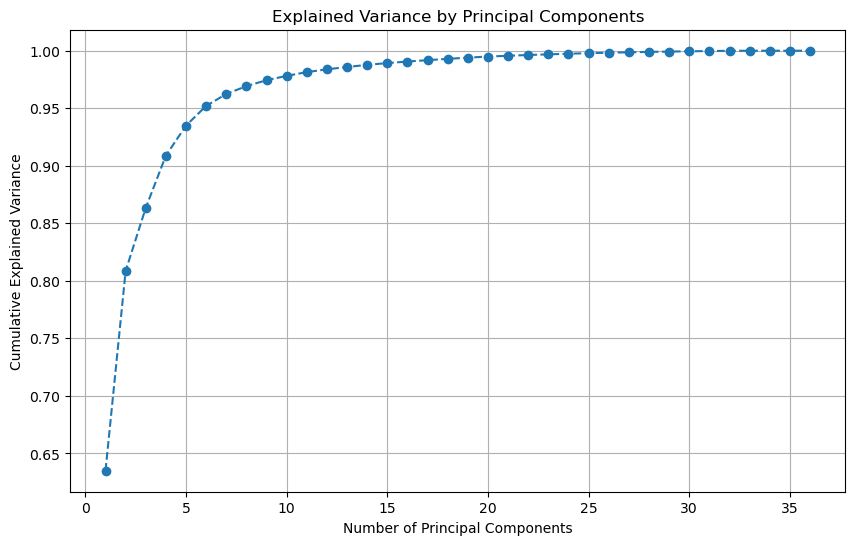

In [15]:
import matplotlib.pyplot as plt

# Fit PCA to explore explained variance
pca_full = PCA()
pca_full.fit(temperature_scaled)

# Plot the explained variance ratio for all components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

The first 5-6 components explain a significant portion of the variance (~90% cumulative variance). This suggests that the temperature-related data has a strong underlying structure, and most of the information can be captured by these component.

**Using only the first principal component (PC1) for the Heat Index should work well, as it captures the most significant variance in the temperature data, about 81% of the explained variance comes from the PC1.** 

In [16]:
# Apply PCA
pca = PCA(n_components=1)  # Reduce to a single component for Heat Index
heat_index = pca.fit_transform(temperature_scaled)

# Add the Heat Index back to the original dataset (aligning indices)
merged_data['Heat Index'] = pd.Series(heat_index.flatten(), index=temperature_data_cleaned.index)

# Calculate Heat Deviation
heat_index_mean = merged_data['Heat Index'].mean()
merged_data['Heat Deviation'] = merged_data['Heat Index'] - heat_index_mean


In [17]:
# Save the updated dataset if needed
UPDATED_PATH = 'data/processed/merged_with_features.csv'
merged_data.to_csv(UPDATED_PATH, index=False)
print(f"Updated dataset with 'New Features' column saved to {UPDATED_PATH}")

Updated dataset with 'New Features' column saved to data/processed/merged_with_features.csv
